## Neural Networks
### Lab session 4: Graph neural networks (with [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/))

In [ ]:
# Check other installation instructions here: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html --quiet

     |████████████████████████████████| 286 kB 664 kB/s 
     |████████████████████████████████| 641 kB 23.1 MB/s 
     |████████████████████████████████| 311 kB 879 kB/s 
     |████████████████████████████████| 121 kB 43.2 MB/s 
     |████████████████████████████████| 467 kB 5.2 MB/s 


In [ ]:
# We will use PyTorch Lightning for training the model, instead of writing the 
# training loop ourselves: https://www.pytorchlightning.ai/
%pip install pytorch-lightning --quiet

     |████████████████████████████████| 798 kB 5.1 MB/s 
     |████████████████████████████████| 125 kB 39.8 MB/s 
     |████████████████████████████████| 529 kB 51.5 MB/s 
     |████████████████████████████████| 87 kB 6.3 MB/s 


In [ ]:
# Note: The version should match the one we used to install PyTorch Geometric (PyG)
import torch
import torch.nn.functional as F
print(torch.__version__)

1.12.1+cu113


In [ ]:
import torch_geometric as pygeom
import pytorch_lightning as pylight

In [ ]:
from torchmetrics.functional import accuracy

### Part 1: Loading the dataset

In [ ]:
# The dataset is a graph classification dataset, where each graph corresponds to
# a molecule: https://paperswithcode.com/dataset/mutag
# "cleaned" removes isomorphic (non-distinguishable) graphs
dataset = pygeom.datasets.TUDataset('./mutag', 'MUTAG', cleaned=True)

Extracting mutag/MUTAG/MUTAG.zip
Processing...
Done!


In [ ]:
len(dataset)

135

In [ ]:
# Because each graph dataset has its own characteristics (e.g., node features, edge
# feautures), PyG does not make any assumptions on what is inside each graph. This
# must be checked dataset-by-dataset.
g = dataset[0]

In [ ]:
# Node feature matrix (nodes, features)
g.x.shape

torch.Size([17, 7])

In [ ]:
# Each node has a one-hot encoding of its type.
g.x[0]
# If you are curious, this is the map: 
ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br']

<BarContainer object of 7 artists>

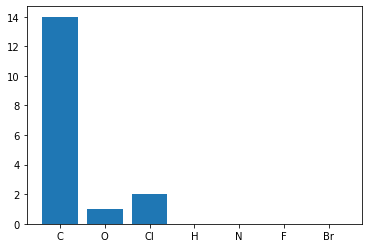

In [ ]:
# Check the distribution of atoms
import matplotlib.pyplot as plt
plt.bar(ATOM_MAP, g.x.sum(0))

In [ ]:
# Each graph has a binary label
g.y

tensor([1])

In [ ]:
# The adjacency matrix is stored as a (2, e) tensor, where e is the numbed of edges.
g.edge_index.shape

torch.Size([2, 38])

In [ ]:
g.edge_index.T[0:10]

tensor([[0, 1],
        [0, 5],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [3, 4],
        [3, 9],
        [4, 3]])

In [ ]:
# The adjacency is undirected, i.e., if (i, j) is present in edge_index, (j, i) is also present.
pygeom.utils.is_undirected(g.edge_index)

True

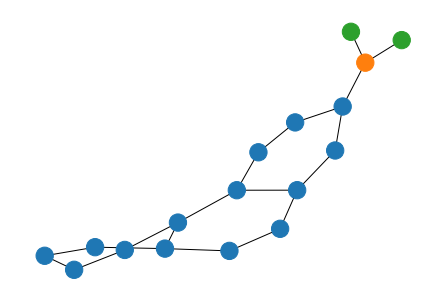

In [ ]:
# We can use NetworkX to draw the graph
import networkx as nx
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(g, to_undirected=True),
        node_color=[colors[i.item()] for i in g.x.argmax(dim=1)])

### Part 2: Transformations

In [ ]:
# PyG has a set of transforms customized for graph-based data:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html
# For example, we can transform the adjacency matrix to a sparse matrix:
g = pygeom.transforms.ToSparseTensor()(g)
print(g.adj_t)

SparseTensor(row=tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
                            8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
                           15, 16]),
             col=tensor([ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
                            7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
                           14, 14]),
             size=(17, 17), nnz=38, density=13.15%)


In [ ]:
# As in torchvision, we can compose multiple transforms when loading
trans = pygeom.transforms.Compose([
    pygeom.transforms.OneHotDegree(10),
])

In [ ]:
dataset = pygeom.datasets.TUDataset('./mutag', 'MUTAG', cleaned=True, transform=trans)

In [ ]:
g = dataset[0]

In [ ]:
# The new features are a one-hot encoding of the degree
g.x.shape

torch.Size([17, 18])

In [ ]:
# Simple train-test split
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(dataset)), stratify = [g.y for g in dataset])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


In [ ]:
train_dataset = dataset[train_idx]
test_dataset = dataset[test_idx]

### Part 3: Mini-batching for graphs

In [ ]:
# PyG has a lot of additional data loaders to perform, e.g., sampling of a subgraph
# from a larger graph: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html
train_loader = pygeom.loader.DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
for batch in train_loader:
  break

In [ ]:
# Node features of all the graphs in the mini-batch
batch.x.shape

torch.Size([161, 18])

In [ ]:
# One label for each graph in the mini-batch
batch.y.shape

torch.Size([8])

In [ ]:
# This corresponds to a block-diagonal adjacency matrix (8 blocks, one for each graph)
batch.edge_index.shape

torch.Size([2, 370])

In [ ]:
# batch.batch[i] = j means that node i belongs to graph j
batch.batch.shape

torch.Size([161])

In [ ]:
batch.batch[0:50]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2])

### Part 4: Model building

In [ ]:
# Check out the cheatsheet for a list of possible layers implemented in PyG:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html
gcnconv = pygeom.nn.GCNConv(18, 32)

In [ ]:
# Note: same trainable parameters as a Linear layer with the same hyper-parameters.
for p in gcnconv.parameters():
  print(p.shape)

torch.Size([32])
torch.Size([32, 18])


In [ ]:
gcnconv(batch.x, batch.edge_index).shape

torch.Size([161, 32])

In [ ]:
# If you do not know PyTorch Lightning, read the 15-minutes intro here:
# https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction.html

In [ ]:
class SimpleGNN(pylight.LightningModule):
  # Simple GNN with 2 GC layers, graph pooling, and a dense layer at the end.

  def __init__(self):
    super().__init__()
    self.gc1 = pygeom.nn.GCNConv(18, 64)
    self.gc2 = pygeom.nn.GCNConv(64, 64)
    self.dense = torch.nn.Linear(64, 1)

  def forward(self, batch):
    # Note how each layer has its own requirements in terms of inputs, e.g.,
    # for graph pooling we need the batch tensor, for GCNConv we need the
    # adjacency matrix.
    out = F.relu(self.gc1(batch.x, batch.edge_index))  # (nodes, 64)
    out = F.relu(self.gc2(out, batch.edge_index))      # (nodes, 64)
    out = pygeom.nn.global_mean_pool(out, batch.batch) # (graphs, 64)
    return self.dense(out)

  # From here below, it's PyTorch Lightning code

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters())

  def training_step(self, batch, _):
    y_pred = self(batch)
    loss = F.binary_cross_entropy_with_logits(y_pred, batch.y.unsqueeze(1).float())
    return loss

  def validation_step(self, batch, _):
    y_hat = self.forward(batch)
    self.log("val_accuracy", accuracy(y_hat, batch.y.unsqueeze(1)), prog_bar=True, batch_size=8)

In [ ]:
gcn = SimpleGNN()

In [ ]:
gcn(batch).shape

torch.Size([8, 1])

### Part 5: Training the model

In [ ]:
# We can use callbacks to add additional functionalities during training:
# https://pytorch-lightning.readthedocs.io/en/stable/api_references.html#callbacks

In [ ]:
# Let us experiment with some early stopping
es_callback = pylight.callbacks.EarlyStopping('val_accuracy', patience=3, mode='max')

In [ ]:
trainer = pylight.Trainer(max_epochs=100, callbacks=[es_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# We also initialize the validation loader
val_loader = pygeom.loader.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
trainer.fit(gcn, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 1.2 K 
1 | gc2   | GCNConv | 4.2 K 
2 | dense | Linear  | 65    
----------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]